# COMP5329 - Deep Learning - Assignment 2 - StudentID : 540309652

## Import librairies

In [380]:
import os
import re

import csv

from PIL import Image
from io import StringIO

import statistics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from tqdm import tqdm
import time

import requests

# pip install transformers datasets evaluate accelerate if you don't have them
from transformers import CLIPProcessor, CLIPModel, ViTImageProcessor, ViTForImageClassification

In [264]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

We are using CPU.


## Load Dataset

In [ ]:
os.getcwd()

In [262]:
# to change depending on where you stored the dataset
DIR = './COMP5329S1A2Dataset/'

TRAIN_CSV = os.path.join(DIR, "train.csv")
TEST_CSV = os.path.join(DIR, "test.csv")
IMAGES_DIR = os.path.join(DIR, "data")

In [265]:
class MultiLabelDataset(Dataset):
    '''
    The Dataset Class, child of torch.utils.data.Dataset.

    Attributes:
    csv_file (str): A string representation of the file directory to the csv data file.
    image_dir (str): A string representation of the file directory to the images data file.
    '''

    def __init__(self, csv_file, image_dir, transform=None, target_transform=None, has_labels = True):
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform
        self.has_labels = has_labels

        with open(csv_file) as file:
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
            self.dataframe = pd.read_csv(StringIO(''.join(lines)), escapechar="/")


    def __len__(self):
        '''
        Returns the length of the dataframe representation of the csv component of the dataset.
        '''
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        '''
        Reads the data from the dataframe then outputs the observation's image tensor, OHE label tensor (if there are labels present), ImageID string and caption string in a tuple form.
      '''

        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.image_dir,
                                self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')])

        img = Image.open(img_path).convert("RGB")

        img_id = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')]
        caption = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Caption')]

        if self.has_labels:
            labels = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Labels')]
            labels = labels.split(' ') # converts the string into an iterable Python list
            labels = [int(x) for x in labels]
            if self.target_transform:
                labels = self.target_transform(labels)
            if self.transform:
                img = self.transform(img)

            sample = (img, labels, img_id, caption)

        else:
            if self.transform:
                img = self.transform(img)
            sample = (img, img_id, caption)

        return sample

## Image statistics for Normalization (optional)

In [ ]:
# NUM_LABELS = 19
# BATCH_SIZE = 1

# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# train_dataset_check = MultiLabelDataset(csv_file = TRAIN_CSV,
#                                  image_dir = IMAGES_DIR,
#                                  transform = transform,
#                                  target_transform = transforms.Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
#                                   has_labels = True,
#                                  )

# def image_stats(checking_dataloader):
#   '''
#   A function to calculate the channel means and standard deviations of the image input in a training dataset.
#   Sums the channel means & squared means per image, then calculates the overall mean and standard deviation by taking the first moment (mean) and square root of the second moment (variance).
#   '''

#   sum_channels, sumsq_channels, n_batches = 0, 0, 0

#   for step, (x, _, _, _ ) in enumerate(checking_dataloader):
#     sum_channels += torch.mean(x, dim = [0, 2, 3])
#     sumsq_channels += torch.mean(x**2 , dim = [0, 2, 3])
#     n_batches += 1

#   means = sum_channels/n_batches
#   stdevs = (sumsq_channels/n_batches - means**2)**0.5

#   return means, stdevs

# train_dataloader_check = DataLoader(train_dataset_check, batch_size=BATCH_SIZE, shuffle=False)

# means, stdevs = image_stats(train_dataloader_check)
# print(f'Mean is: {means} \n Standard Deviation is: {stdevs}')

# def get_image_sizes(checking_dataloader):
#     '''
#     Obtains the heights and widths of the images within the supplied dataset.
#     '''

#     heights, widths = [], []

#     for step, (img, _, _, _) in enumerate(checking_dataloader):
#         heights.append(img.size()[2])
#         widths.append(img.size()[3])

#     return heights, widths

# heights, widths = get_image_sizes(train_dataloader_check)

# print(f'Median height is: {statistics.median(heights)}')
# print(f'Mean height is: {statistics.mean(heights)}')
# print(f'Median width is: {statistics.median(widths)}')
# print(f'Mean width is: {statistics.mean(widths)}')

## Create train/test/validation set (dataloaders)

In [332]:
# Concluded 19 labels - one-hot encoded. Leaving label 12 in there as it'll just have zeros for this index
NUM_LABELS = 19
BATCH_SIZE = 50
RESIZE_SIZE = 256
CROP_SIZE = 224 # Seems to be the standard image size used (224)
TRAIN_VAL_PROP = 0.8
SEED = 5329

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), #ImageNet stats
    transforms.Resize(RESIZE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(CROP_SIZE)
])

# The train/val dataset available with labels
train_all_dataset = MultiLabelDataset(csv_file = TRAIN_CSV,
                            image_dir = IMAGES_DIR,
                            transform = transform,
                            target_transform = transforms.Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                            has_labels = True
                            )

# Need to further split it up
train_dataset, val_dataset = random_split(train_all_dataset,
                                          [int(round(TRAIN_VAL_PROP * len(train_all_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(train_all_dataset)))],
                                          generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = MultiLabelDataset(csv_file = TEST_CSV,
                                 image_dir = IMAGES_DIR,
                                transform = transform,
                                 has_labels = False)

train_all_dataloader = DataLoader(train_all_dataset, batch_size = BATCH_SIZE, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 4788, 14713, 14958, 29878 can't be read ?

In [ ]:
# Just a cell to see what were the missing rows (because length is 29996)

# Batch_size has to be 1 to run this cell
# i = 0
# for _, _, img_id, _ in tqdm(train_all_dataloader):
#     if int(img_id[0][0:-4])!=i:
#         print("False: ", int(img_id[0][0:-4]), i)
#         i = i+1
#     i += 1

# 4788, 14713, 14958, 29878 can't be read ?

## Show samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img_ids:  ('29547.jpg', '17740.jpg', '5306.jpg', '11411.jpg', '17288.jpg', '16024.jpg')
captions:  ('A lady on a pink bike wearing a blue dress and pink boots.', 'A man buying bananas from a fruit vendor.', 'A woman holding a white plate with lots of carrots on it.', 'A Stop sign and other road signs on a city street', 'Two double decker busses on the street while a man is crossing.', 'A CGI image of a man standing next to a woman.')
Labels : tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=torch.uint8)


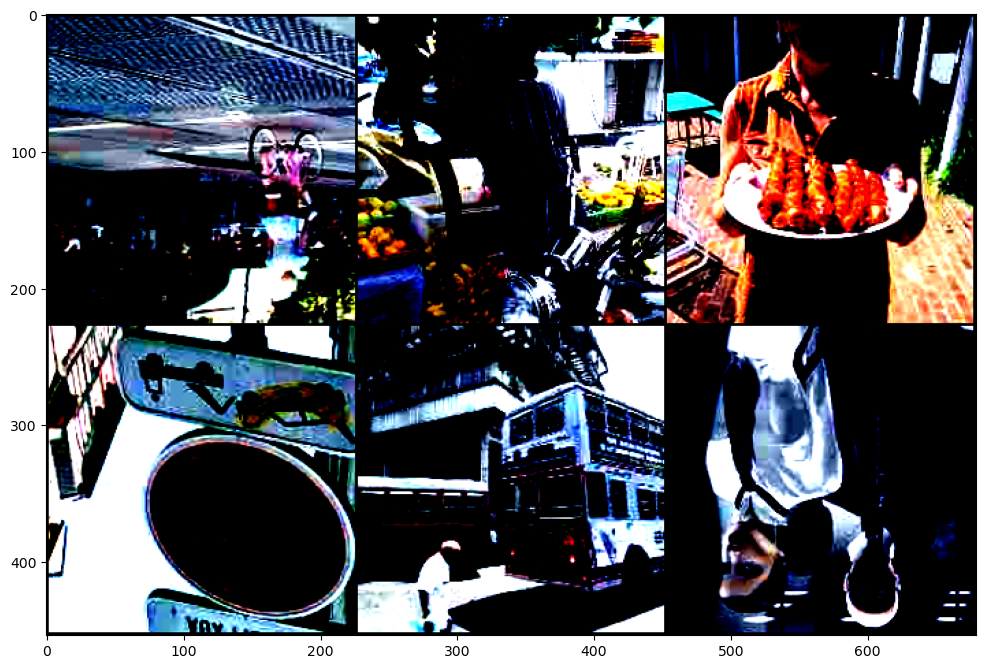

In [333]:
def show_img():
  '''
  A function to show a 2 x 3 plot of 6 random images and display the one-hot encoded labels above it.

  Parameters:
  dataset (AssignmentDataset): The dataset containing the desired set of images for which samples are to be plotted.

  Returns:
  None
  '''

  loader = DataLoader(train_dataset, batch_size = 6, shuffle = True)
  batch = next(iter(loader))
  images, labels, img_ids, captions = batch

  grid = torchvision.utils.make_grid(images, nrow = 3)
  plt.figure(figsize = (12, 12))

  print("img_ids: ", img_ids)
  plt.imshow(np.transpose(grid, (1,2,0)))
  print("captions: ", captions)
  print("Labels :", labels)

show_img()

## CV with CNN

### Custom Models

In [ ]:
class AlexNet_Reduced(nn.Module):

    def __init__(self, num_classes=19, stem_stride=4):
        # invoke super class initialisation method
        super(AlexNet_Reduced, self).__init__()

        # define the CNN:
        # 1. define feature extraction layers
        self.features = nn.Sequential(
            # conv-relu-pooling
            nn.Conv2d(3, 2, kernel_size=11, stride=stem_stride, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-pooling
            # nn.Conv2d(64, 256, kernel_size=5, padding=2),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-conv-relu-conv-relu-pooling
            # nn.Conv2d(192, 384, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(384, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.Conv2d(2, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # 2. define average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # 3. define fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),                   # use dropout
            nn.Linear(4 * 6 * 6, 8),
            nn.ReLU(inplace=True),
            # nn.Dropout(),                   # use dropout
            # nn.Linear(4096, 4096),
            # nn.ReLU(inplace=True),
            nn.Linear(8, num_classes),
            nn.Sigmoid()
        )

    # define forward-propagation
    def forward(self, x):
        # feature extraction
        x = self.features(x)
        # adaptive pooling
        x = self.avgpool(x)
        # flat the feature map
        x = torch.flatten(x, 1)
        # classification
        x = self.classifier(x)
        return x

    # back-propagation is handled by PyTorch

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=19):  # Default to 19 classes unless specified otherwise
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((9, 9))
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 512),  # Adjust the input features according to the output of the last conv layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),  # Set the number of output features to match the number of classes
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the output from the convolutional layers
        x = self.classifier(x)
        return x

### Pretrained Models

In [ ]:
def initialize_googlenet_pretrained_model(num_labels):
    model = models.googlenet(weights='DEFAULT')
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, num_labels),
        nn.Sigmoid()
    )
    print(model.fc)
    return model

In [ ]:
def initialize_squeezenet_pretrained_model(num_labels):
    model = models.squeezenet1_1(weights='DEFAULT')
    model.classifier[1] = nn.Conv2d(model.classifier[1].in_channels, num_labels, kernel_size=(1, 1), stride=(1, 1))
    model.classifier.add_module('4', nn.Sigmoid())
    return model

### Train and Test Loops

In [216]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    losses = []
    for batch_idx, (inputs, labels, _, _) in tqdm(enumerate(dataloader)):

        # if batch_idx > 10: # to test on smaller datasets
        #      break

        # clear gradients of parameters optimized by the optimizer (because PyTorch accumulates gradients)
        optimizer.zero_grad()
        # Compute prediction and loss
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.float())
        losses.append(loss.item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        # if batch_idx % 10 == 0:
        #     print(loss.item())
        
    return np.mean(losses)
        

def validate_loop(dataloader, model, threshold=0.5):
    model.eval()
    accuracies, f1_scores = [], []
    with torch.no_grad():
        for idx, (input, label, _, _) in tqdm(enumerate(dataloader)):

            # if idx > 10: # to test on smaller datasets
            #     break
            
            output = model(input)
            predicted_label = (output > threshold).float()

            predicted_label_numpy = torch.Tensor.numpy(predicted_label)[0]
            label_numpy = torch.Tensor.numpy(label)[0]
            accuracies.append(accuracy_score(predicted_label_numpy, label_numpy))
            f1_scores.append(f1_score(predicted_label_numpy, label_numpy, average='macro', zero_division = 0))

    print("Accuracy:", np.mean(accuracies))    
    print("F1 score:", np.mean(f1_scores))

### Training (train only squeezenet)

Epoch 1


1it [00:02,  2.69s/it]

2.7795023918151855


11it [00:24,  2.19s/it]

0.6973772644996643


11it [00:25,  2.30s/it]


Epoch 2


1it [00:02,  2.50s/it]

0.6968578100204468


11it [00:25,  2.21s/it]

0.6948397159576416


11it [00:25,  2.36s/it]


Epoch 3


1it [00:02,  2.37s/it]

0.6946858167648315


11it [00:25,  2.34s/it]

0.6888760924339294


11it [00:26,  2.36s/it]


Epoch 4


1it [00:02,  2.55s/it]

0.696036696434021


11it [00:28,  2.71s/it]

0.6801344752311707


11it [00:29,  2.64s/it]


Epoch 5


1it [00:02,  2.49s/it]

0.685671865940094


11it [00:28,  2.43s/it]

0.6866503953933716


11it [00:29,  2.66s/it]


Epoch 6


1it [00:02,  2.34s/it]

0.6883152723312378


11it [00:24,  2.20s/it]

0.6897391676902771


11it [00:24,  2.27s/it]


Epoch 7


1it [00:02,  2.44s/it]

0.6904413104057312


11it [00:24,  2.18s/it]

0.683175265789032


11it [00:24,  2.26s/it]


Epoch 8


1it [00:02,  2.10s/it]

0.6870285868644714


11it [00:24,  2.16s/it]

0.6859145164489746


11it [00:24,  2.24s/it]


Epoch 9


1it [00:02,  2.40s/it]

0.6829609274864197


11it [00:23,  2.19s/it]

0.6852704286575317


11it [00:24,  2.24s/it]


Epoch 10


1it [00:02,  2.29s/it]

0.6841126680374146


11it [00:23,  2.17s/it]

0.6832358241081238


11it [00:24,  2.25s/it]

Done!
Model Trained - training time: 4:19


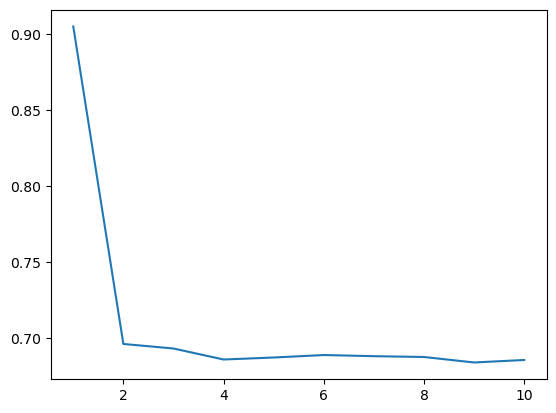

In [217]:
# model = initialize_googlenet_pretrained_model(19)
model = initialize_squeezenet_pretrained_model(19)
# model = AlexNet_Reduced()
# model = CustomCNN(num_classes=19)
loss_fn = nn.BCELoss()

LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Start timing
t0 = time.time()

NUM_EPOCHS = 20
losses = []
for t in range(NUM_EPOCHS):
    print("=====================")
    print(f"Epoch {t+1}")
    print("=====================")
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(loss)
    validate_loop(val_dataloader, model, threshold=0.5)
print("Done!")

# End timing
t1 = time.time()
print("Model Trained - training time: %i:%i" % ((t1 - t0) // 60, (t1 - t0) % 60))


plt.plot(np.arange(1, NUM_EPOCHS+1), losses)
plt.title('Squeezenet learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Test inference

In [220]:
threshold = 0.5
predicted_labels = []
rows = [['ImageID', 'Labels']]

with torch.no_grad():
    model.eval()
    for idx, (img, id, _) in tqdm(enumerate(test_dataloader)):

        # if idx > 10: # to test on smaller datasets
        #     break
        output = model(img)
        predicted_label = (output > threshold).float()
        predicted_label_numpy = torch.Tensor.numpy(predicted_label)[0]
        line = [id[0]]
        label = []
        for i in range(predicted_label_numpy.shape[0]):
            if predicted_label_numpy[i] == 1:
                label.append(str(i+1))
        label = ' '.join(label)
        line.append(label)
        rows.append(line)

with open("submission_image_only_squeezenet.csv", 'w') as file:
    writer = csv.writer(file, delimiter=',', lineterminator='\n')
    writer.writerows(rows)
        

10000it [07:03, 23.62it/s]


## NLP with LSTM

### Prepare data

In [ ]:
# Tokenize the sentences and map words to indices
word_to_index = {}
index = 0
for _, _, _, caption in tqdm(DataLoader(train_all_dataset, batch_size = 1)):
    caption = caption[0]
    for word in caption.split():
        if word not in word_to_index:
            word_to_index[word] = index
            index += 1

for _, _, caption in tqdm(DataLoader(test_dataset, batch_size = 1)):
    caption = caption[0]
    for word in caption.split():
        if word not in word_to_index:
            word_to_index[word] = index
            index += 1

In [ ]:
# Convert sentences to sequences of word indices
X_train = []
y_train = []
for _, label, _, caption in tqdm(DataLoader(train_dataset, batch_size = 1)):
    caption = caption[0]
    indices = [word_to_index[word] for word in caption.split()]
    X_train.append(indices)
    y_train.append(label)

# Pad sequences to ensure they have the same length
max_seq_length = max(len(seq) for seq in X_train)
X_train_padded = [seq + [0] * (max_seq_length - len(seq)) for seq in X_train]

# Convert to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train_padded)
y_train_tensor = torch.cat(y_train)

In [ ]:
# Convert sentences to sequences of word indices
X_val = []
y_val = []
for _, label, _, caption in tqdm(val_dataloader):
    caption = caption[0]
    indices = [word_to_index[word] for word in caption.split()]
    X_val.append(indices)
    y_val.append(label)

# Pad sequences to ensure they have the same length
max_seq_length = max(len(seq) for seq in X_val)
X_val_padded = [seq + [0] * (max_seq_length - len(seq)) for seq in X_val]

# Convert to PyTorch tensors
X_val_tensor = torch.LongTensor(X_val_padded)
y_val_tensor = torch.cat(y_val)

In [ ]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
val_loader = DataLoader(
    dataset=val_data, 
    batch_size=1, 
    shuffle=False
)

### LSTM Classifier

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last time step's output
        output = self.fc(lstm_out)
        return output

### Train and Test Loops

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    losses = []
    for batch_idx, (captions, labels) in tqdm(enumerate(dataloader)):
        # clear gradients of parameters optimized by the optimizer (because PyTorch accumulates gradients)
        optimizer.zero_grad()
        # Compute prediction and loss
        outputs = model(captions)
        loss = loss_fn(outputs, labels.float())
        losses.append(loss.item())
        # Backpropagation
        loss.backward()
        optimizer.step()

    return np.mean(losses)

def validate_loop(dataloader, model, threshold=0.5):
    model.eval()
    accuracies, f1_scores = [], []
    with torch.no_grad():
        for idx, (caption, label) in tqdm(enumerate(dataloader)):
            output = model(caption)
            predicted_label = (output > threshold).float()

            predicted_label_numpy = torch.Tensor.numpy(predicted_label)[0]
            label_numpy = torch.Tensor.numpy(label)[0]
            accuracies.append(accuracy_score(predicted_label_numpy, label_numpy))
            f1_scores.append(f1_score(predicted_label_numpy, label_numpy, average='macro', zero_division = 0))

    print("Accuracy:", np.mean(accuracies))    
    print("F1 score:", np.mean(f1_scores))

### Training

In [ ]:
vocab_size = len(word_to_index)  # Size of the vocabulary
embedding_dim = 50  # Dimension of word embeddings
hidden_dim = 128  # Dimension of the hidden state in the LSTM
output_dim = 19  # Dimension of the output (binary classification)

# Create an instance of the LSTM classifier
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
print(model)

loss_fn = nn.BCELoss()

LR = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Start timing
t0 = time.time()

NUM_EPOCHS = 10
losses = []
for t in range(NUM_EPOCHS):
    print("===================")
    print(f"Epoch {t+1}")
    print("===================")
    loss = train_loop(train_loader, model, loss_fn, optimizer)
    losses.append(loss)
    validate_loop(val_loader, model, threshold=0.5)
print("Done!")

# End timing
t1 = time.time()
print("Model Trained - training time: %i:%i" % ((t1 - t0) // 60, (t1 - t0) % 60))

plt.plot(np.arange(1, NUM_EPOCHS+1), losses)
plt.title('LSTM learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Test inference

In [ ]:
# Convert sentences to sequences of word indices
X_test = []
Id = []
for _, img_id, caption in tqdm(test_dataloader):
    caption = caption[0]
    indices = [word_to_index[word] for word in caption.split()]
    X_test.append(indices)
    Id.append(img_id)

# Pad sequences to ensure they have the same length
max_seq_length = max(len(seq) for seq in X_test)
X_test_padded = [seq + [0] * (max_seq_length - len(seq)) for seq in X_test]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_ids, tokenized_captions):
        self.image_ids = image_ids
        self.tokenized_captions = tokenized_captions

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        tokenized_caption = self.tokenized_captions[idx]
        return image_id, tokenized_caption

In [ ]:
# Convert to PyTorch tensors
X_test_tensor = torch.LongTensor(X_test_padded)

test_data = CustomDataset(Id, X_test_tensor)

test_loader = DataLoader(
    dataset=test_data, 
    batch_size=1, 
    shuffle=False
)

In [ ]:
threshold = 0.5
predicted_labels = []
rows = [['ImageID', 'Labels']]

with torch.no_grad():
    model.eval()
    for idx, (id, caption) in tqdm(enumerate(test_loader)):

        # if idx > 10: # to test on smaller datasets
        #     break
        output = model(caption)
        predicted_label = (output > threshold).float()
        predicted_label_numpy = torch.Tensor.numpy(predicted_label)[0]
        
        line = [id[0][0]]
        label = []
        for i in range(predicted_label_numpy.shape[0]):
            if predicted_label_numpy[i] == 1:
                label.append(str(i+1))
        label = ' '.join(label)
        line.append(label)
        rows.append(line)

with open("submission_text_only.csv", 'w') as file:
    writer = csv.writer(file, delimiter=',', lineterminator='\n')
    writer.writerows(rows)
    

## CLIP (not good for this task, don't run this section, unless you have time).

CLIP is the model that finds the similarity between an image and a caption/label. It would have worked for our tasks if the labels were words and not numbers.

### Preprocessing

In [322]:
# Only for CLIP

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

transform = transforms.Compose([
    transforms.ToTensor(),
])

# The train/val dataset available with labels
train_all_dataset = MultiLabelDataset(csv_file = TRAIN_CSV,
                            image_dir = IMAGES_DIR,
                            transform = transform,
                            target_transform = transforms.Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                            has_labels = True
                            )

# Need to further split it up
train_dataset, val_dataset = random_split(train_all_dataset,
                                          [int(round(TRAIN_VAL_PROP * len(train_all_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(train_all_dataset)))],
                                          generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = MultiLabelDataset(csv_file = TEST_CSV,
                                 image_dir = IMAGES_DIR,
                                transform = transform,
                                 has_labels = False)

train_all_dataloader = DataLoader(train_all_dataset, batch_size = 1, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

c:\Users\mqtho\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Train and Test Loops

In [328]:
text = [str(i) for i in range(19)]

def train_loop(dataloader, model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    losses = []
    for batch_idx, (img, labels, _, _) in tqdm(enumerate(dataloader)):

        if batch_idx > 10: # to test on smaller datasets
            break

        # clear gradients of parameters optimized by the optimizer (because PyTorch accumulates gradients)
        optimizer.zero_grad()
        
        inputs = processor(text=text, images=img, return_tensors="pt", padding=True)

        # Compute prediction and loss
        output = model(**inputs)
        logits_per_image = output.logits_per_image  # this is the image-text similarity score
        predicted_labels = logits_per_image.sigmoid()  # we can take the sigmoid to get the labels
        
        loss = loss_fn(predicted_labels, labels.float())
        losses.append(loss.item())
        # Backpropagation
        loss.backward()
        optimizer.step()

        # if batch_idx % 10 == 0:
        #     print(loss.item())
        
    return np.mean(losses)
        

def validate_loop(dataloader, model, threshold=0.5):
    model.eval()
    accuracies, f1_scores = [], []
    with torch.no_grad():
        for idx, (img, label, _, _) in tqdm(enumerate(dataloader)):

            if idx > 10: # to test on smaller datasets
                break
            
            inputs = processor(text=text, images=img, return_tensors="pt", padding=True)

            output = model(**inputs)
            logits_per_image = output.logits_per_image  # this is the image-text similarity score
            predicted_label = logits_per_image.sigmoid()  # we can take the sigmoid to get the labels
            predicted_label = (predicted_label > threshold).float()[0]
            predicted_label_numpy = torch.Tensor.numpy(predicted_label)
            label_numpy = torch.Tensor.numpy(label)[0]
            accuracies.append(accuracy_score(predicted_label_numpy, label_numpy))
            f1_scores.append(f1_score(predicted_label_numpy, label_numpy, average='macro', zero_division = 0))

    print("Accuracy:", np.mean(accuracies))    
    print("F1 score:", np.mean(f1_scores))

### Training

Epoch 1


11it [00:37,  3.45s/it]
11it [00:03,  3.15it/s]


Accuracy: 0.10526315789473682
F1 score: 0.09173510942285645
Epoch 2


11it [00:39,  3.57s/it]
11it [00:04,  2.69it/s]


Accuracy: 0.10526315789473682
F1 score: 0.09173510942285645
Epoch 3


11it [00:36,  3.34s/it]
11it [00:04,  2.65it/s]


Accuracy: 0.10526315789473682
F1 score: 0.09173510942285645
Epoch 4


11it [00:38,  3.51s/it]
11it [00:05,  1.84it/s]


Accuracy: 0.10526315789473682
F1 score: 0.09173510942285645
Epoch 5


11it [00:37,  3.40s/it]
11it [00:03,  3.14it/s]

Accuracy: 0.10526315789473682
F1 score: 0.09173510942285645
Done!
Model Trained - training time: 3:31


Text(0, 0.5, 'Loss')

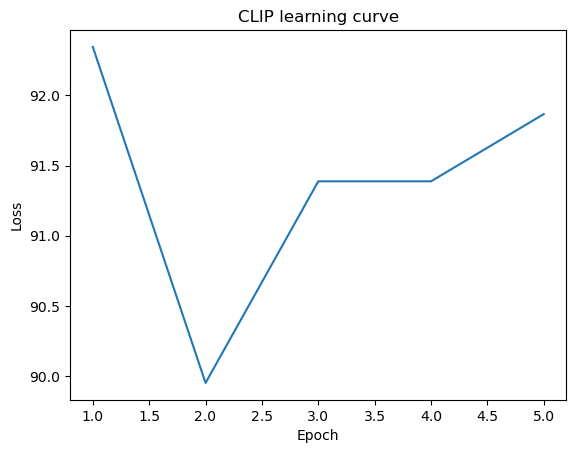

In [330]:
loss_fn = nn.BCELoss()

LR = 5
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Start timing
t0 = time.time()

NUM_EPOCHS = 5
losses = []
for t in range(NUM_EPOCHS):
    print("=====================")
    print(f"Epoch {t+1}")
    print("=====================")
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(loss)
    validate_loop(val_dataloader, model, threshold=0.5)
print("Done!")

# End timing
t1 = time.time()
print("Model Trained - training time: %i:%i" % ((t1 - t0) // 60, (t1 - t0) % 60))


plt.plot(np.arange(1, NUM_EPOCHS+1), losses)
plt.title('CLIP learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Test inference

In [250]:
threshold = 0.5
predicted_labels = []
rows = [['ImageID', 'Labels']]

text = [str(i) for i in range(19)]

# inference
with torch.no_grad():
    model.eval()
    for img, id, _ in tqdm(test_dataloader):

        inputs = processor(text=text, images=img, return_tensors="pt", padding=True)

        # if idx > 10: # to test on smaller datasets
        #     break
        output = model(**inputs)
        logits_per_image = output.logits_per_image  # this is the image-text similarity score
        predicted_label = logits_per_image.sigmoid()  # we can take the sigmoid to get the labels
        predicted_label = (predicted_label > threshold).float()[0]
        line = [id[0]]
        label = []
        for i in range(predicted_label.shape[0]):
            if predicted_label[i] == 1:
                label.append(str(i+1))
        label = ' '.join(label)
        line.append(label)
        rows.append(line)

# writing in file for submission
with open("submission_image_only_clip.csv", 'w') as file:
    writer = csv.writer(file, delimiter=',', lineterminator='\n')
    writer.writerows(rows)

100%|██████████| 10000/10000 [39:00<00:00,  4.27it/s]


## Vision Transformer

### Initialization of model

In [390]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

def initialize_vit_pretrained_model(num_labels):
    model = ViTForImageClassification.from_pretrained(model_name_or_path, num_labels=num_labels)
    return model

def vit_processor(image):
    return processor(image, return_tensors='pt')['pixel_values'][0]

c:\Users\mqtho\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Image preprocessing

In [391]:
# Concluded 19 labels - one-hot encoded. Leaving label 12 in there as it'll just have zeros for this index
NUM_LABELS = 19
BATCH_SIZE = 2
TRAIN_VAL_PROP = 0.8
SEED = 5329

transform = vit_processor

# The train/val dataset available with labels
train_all_dataset = MultiLabelDataset(csv_file = TRAIN_CSV,
                            image_dir = IMAGES_DIR,
                            transform = transform,
                            target_transform = transforms.Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                            has_labels = True
                            )

# Need to further split it up
train_dataset, val_dataset = random_split(train_all_dataset,
                                          [int(round(TRAIN_VAL_PROP * len(train_all_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(train_all_dataset)))],
                                          generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = MultiLabelDataset(csv_file = TEST_CSV,
                                 image_dir = IMAGES_DIR,
                                transform = transform,
                                 has_labels = False)

train_all_dataloader = DataLoader(train_all_dataset, batch_size = BATCH_SIZE, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [389]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

print(processor(image, return_tensors='pt')['pixel_values'][0].shape)
print(processor(image, return_tensors='pt').keys())

outputs = model(processor(image, return_tensors='pt')['pixel_values'])
logits = outputs.logits
pred = logits.sigmoid()
print(pred > 0.5)

c:\Users\mqtho\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([3, 224, 224])
dict_keys(['pixel_values'])
tensor([[ True,  True,  True,  True, False,  True, False, False,  True, False,
         False, False,  True, False,  True, False,  True,  True, False]])


In [398]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    losses = []
    for batch_idx, (images, labels, _, _) in tqdm(enumerate(dataloader)):

        # if batch_idx > 10: # to test on smaller datasets
        #     break

        # clear gradients of parameters optimized by the optimizer (because PyTorch accumulates gradients)
        optimizer.zero_grad()
        # Compute prediction and loss
        outputs = model(images)
        loss = loss_fn(outputs.logits.sigmoid(), labels.float())
        losses.append(loss.item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        # if batch_idx % 10 == 0:
        #     print(loss.item())
        
    return np.mean(losses)
        

def validate_loop(dataloader, model, threshold=0.5):
    model.eval()
    accuracies, f1_scores = [], []
    with torch.no_grad():
        for idx, (image, label, _, _) in tqdm(enumerate(dataloader)):

            # if idx > 10: # to test on smaller datasets
            #     break
            
            output = model(image)
            predicted_label = (output.logits.sigmoid() > threshold).float()
            predicted_label_numpy = torch.Tensor.numpy(predicted_label)[0]
            label_numpy = torch.Tensor.numpy(label)[0]
            accuracies.append(accuracy_score(predicted_label_numpy, label_numpy))
            f1_scores.append(f1_score(predicted_label_numpy, label_numpy, average='macro', zero_division = 0))

    print("Accuracy:", np.mean(accuracies))    
    print("F1 score:", np.mean(f1_scores))

### Training

c:\Users\mqtho\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1


11it [00:29,  2.65s/it]


Epoch 2


11it [00:28,  2.63s/it]


Epoch 3


11it [00:28,  2.61s/it]


Epoch 4


11it [00:34,  3.15s/it]


Epoch 5


11it [00:31,  2.83s/it]


Epoch 6


11it [00:34,  3.12s/it]


Epoch 7


11it [00:32,  2.93s/it]


Epoch 8


11it [00:33,  3.01s/it]


Epoch 9


11it [00:32,  2.95s/it]


Epoch 10


11it [00:30,  2.74s/it]

Done!
Model Trained - training time: 5:14


Text(0, 0.5, 'Loss')

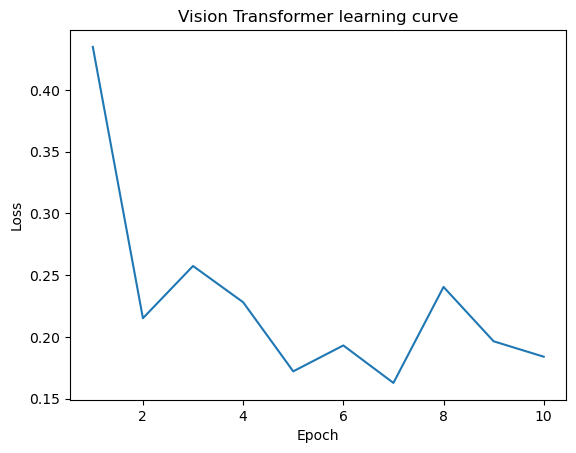

In [399]:
model = initialize_vit_pretrained_model(19)
loss_fn = nn.BCELoss()

LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Start timing
t0 = time.time()

NUM_EPOCHS = 10
losses = []
for t in range(NUM_EPOCHS):
    print("=====================")
    print(f"Epoch {t+1}")
    print("=====================")
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    losses.append(loss)
    # validate_loop(val_dataloader, model, threshold=0.5)
print("Done!")

# End timing
t1 = time.time()
print("Model Trained - training time: %i:%i" % ((t1 - t0) // 60, (t1 - t0) % 60))


plt.plot(np.arange(1, NUM_EPOCHS+1), losses)
plt.title('Vision Transformer learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Test inference

In [402]:
threshold = 0.5
predicted_labels = []
rows = [['ImageID', 'Labels']]

with torch.no_grad():
    model.eval()
    for idx, (img, id, _) in tqdm(enumerate(test_dataloader)):

        if idx > 150: # to test on smaller datasets
            break
        
        output = model(img)
        predicted_label = (output.logits.sigmoid() > threshold).float()
        predicted_label_numpy = torch.Tensor.numpy(predicted_label)[0]
        line = [id[0]]
        label = []
        for i in range(predicted_label_numpy.shape[0]):
            if predicted_label_numpy[i] == 1:
                label.append(str(i+1))
        label = ' '.join(label)
        line.append(label)
        rows.append(line)

with open("submission_image_only_vit.csv", 'w') as file:
    writer = csv.writer(file, delimiter=',', lineterminator='\n')
    writer.writerows(rows)

151it [01:01,  2.46it/s]
